In [1]:
!pip install opendatasets --quiet
import opendatasets as od

In [2]:
od.download("https://www.kaggle.com/datasets/vishakhdapat/imdb-movie-reviews")

Dataset URL: https://www.kaggle.com/datasets/vishakhdapat/imdb-movie-reviews


100%|██████████| 25.7M/25.7M [00:00<00:00, 1.46GB/s]

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv("/content/imdb-movie-reviews/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = BertModel.from_pretrained("google-bert/bert-base-uncased")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
df.isna().sum()

,0
review,0
sentiment,0


In [7]:
df.sentiment.unique()

array(['positive', 'negative'], dtype=object)

In [8]:
import torch
torch.cuda.is_available()


True

In [9]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [11]:
df["label"] = df["sentiment"].map({
    "negative": 0,
    "positive": 1
})

df = df[["review", "label"]]
df.dropna(inplace=True)
df.head()


,review,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [12]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)


In [13]:
tokenizer = BertTokenizer.from_pretrained(
    "google-bert/bert-base-uncased"
)


In [14]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=32,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [15]:
train_dataset = IMDBDataset(
    train_df["review"].tolist(),
    train_df["label"].tolist()
)

test_dataset = IMDBDataset(
    test_df["review"].tolist(),
    test_df["label"].tolist()
)


In [16]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


In [17]:
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained(
            "google-bert/bert-base-uncased"
        )
        self.fc = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        logits = self.fc(cls_embedding)
        return logits


In [18]:
model = BertClassifier().to(device)


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


In [20]:
epochs = 2

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


100%|██████████| 5000/5000 [08:58<00:00,  9.28it/s]


Epoch 1, Loss: 0.4738


100%|██████████| 5000/5000 [08:44<00:00,  9.53it/s]

Epoch 2, Loss: 0.3212


In [21]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("Accuracy:", correct / total)


Accuracy: 0.7963


In [22]:
def predict(text):
    model.eval()
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True
    ).to(device)

    with torch.no_grad():
        logits = model(**enc)
        pred = torch.argmax(logits, dim=1).item()

    return "Positive" if pred == 1 else "Negative"


In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


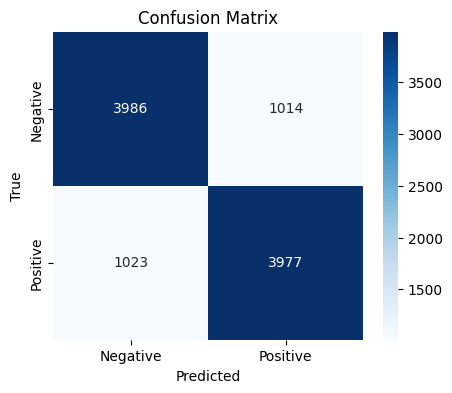

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["Negative", "Positive"]
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [25]:
def predict(text):
    model.eval()
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )

    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        pred = torch.argmax(logits, dim=1).item()

    return "Positive" if pred == 1 else "Negative"


In [26]:
predict("This movie was absolutely fantastic!")


'Positive'

In [27]:
predict("One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked.")

'Positive'

In [28]:
predict("I had the terrible misfortune of having to view this b-movie in it's entirety.")

'Negative'